# Build and Train

In [1]:
import tensorflow as tf
from boltzmann.data.mnist import load_mnist
from boltzmann.generic.base import State, train
from boltzmann.generic.bernoulli import (
    BernoulliBoltzmannMachine, HintonInitializer, LogInternalInformation,
    initialize_fantasy_state, get_reconstruction_error)

IMAGE_SIZE = (16, 16)
SEED = 42

tf.random.set_seed(SEED)

In [2]:
(X, y), _ = load_mnist(image_size=IMAGE_SIZE, binarize=True,
                       minval=0, maxval=1)

ambient_size = IMAGE_SIZE[0] * IMAGE_SIZE[1]
latent_size = 64
batch_size = 128
epochs = 30
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset = dataset.shuffle(10000).repeat(epochs).batch(batch_size)
bm = BernoulliBoltzmannMachine(
    ambient_size=ambient_size,
    latent_size=latent_size,
    initializer=HintonInitializer(X),
    max_step=100,
    tolerance=1e-1,
    connect_ambient_to_ambient=False,
    activate_ratio=0.25,
    seed=SEED,
)
fantasy_state = initialize_fantasy_state(bm, batch_size, SEED)
optimizer = tf.optimizers.Adam()
callbacks = [LogInternalInformation(bm, log_step=100, verbose=True)]
fantasy_state = train(bm, optimizer, dataset, fantasy_state, callbacks=callbacks)

_bias:0: -5.97050 (6.27980) - latent_bias:0: -0.00863 (0.16138) - latent_latent_kernel:0: -0.02069 (0.15850) - recon_error: 0.07874
step: 5500 - real_latent: 0.31836 (0.46584) - ambient_latent_kernel:0: -0.07390 (0.31600) - ambient_bias:0: -5.96948 (6.28073) - latent_bias:0: -0.01056 (0.16419) - latent_latent_kernel:0: -0.02352 (0.15971) - recon_error: 0.07141
step: 5600 - real_latent: 0.30811 (0.46171) - ambient_latent_kernel:0: -0.07525 (0.31956) - ambient_bias:0: -5.97034 (6.27984) - latent_bias:0: -0.01010 (0.17057) - latent_latent_kernel:0: -0.02400 (0.16425) - recon_error: 0.07712
step: 5700 - real_latent: 0.31433 (0.46425) - ambient_latent_kernel:0: -0.07538 (0.32384) - ambient_bias:0: -5.96923 (6.28112) - latent_bias:0: -0.00966 (0.17258) - latent_latent_kernel:0: -0.02509 (0.16667) - recon_error: 0.07202
step: 5800 - real_latent: 0.32227 (0.46734) - ambient_latent_kernel:0: -0.07589 (0.32789) - ambient_bias:0: -5.96828 (6.28124) - latent_bias:0: -0.00921 (0.17719) - latent_lat

In [3]:
get_reconstruction_error(bm, X[:5000])

<tf.Tensor: shape=(), dtype=float32, numpy=0.056194533>

# Visualize the Latent

In [4]:
from sklearn.manifold import TSNE
from boltzmann.generic.base import relax_ambient

def get_relaxed_latent_projection(
        bm, ambient, max_step=100, tolerance=1e-1):
    relaxed_state, _ = relax_ambient(bm, ambient, max_step, tolerance)
    projection = TSNE().fit_transform(relaxed_state.latent)
    return projection

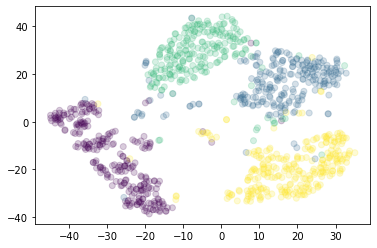

In [5]:
import numpy as np
import matplotlib.pyplot as plt

labels = {1, 2, 3, 4}
X_in_labels, y_in_labels = [], []
for xi, yi in zip(X, y):
    yi = np.argmax(yi)  # y is one-hot encoded.
    if yi in labels:
        X_in_labels.append(xi)
        y_in_labels.append(yi)
    if len(X_in_labels) == 1000:
      break

Z = get_relaxed_latent_projection(bm, np.array(X_in_labels))
plt.scatter(Z[:, 0], Z[:, 1], c=y_in_labels, alpha=0.2)
plt.show()

# Pruning

In [6]:
from boltzmann.generic.base import quantize

qbm = quantize(bm, 1e-1)
get_reconstruction_error(qbm, X[:5000])

<tf.Tensor: shape=(), dtype=float32, numpy=0.057496876>

In [7]:
qbm.latent_latent_kernel

<tf.Variable 'latent_latent_kernel:0' shape=(64, 64) dtype=float32, numpy=
array([[  0.,  -3.,   0., ...,   1.,  -5.,   1.],
       [ -3.,   0.,  -4., ...,   0., -14.,  -3.],
       [  0.,  -4.,   0., ...,   0.,  -3.,  -3.],
       ...,
       [  1.,   0.,   0., ...,   0.,  -1.,   0.],
       [ -5., -14.,  -3., ...,  -1.,   0.,   0.],
       [  1.,  -3.,  -3., ...,   0.,   0.,   0.]], dtype=float32)>

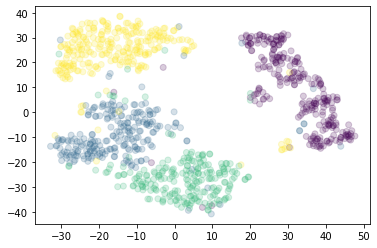

In [8]:
qZ = get_relaxed_latent_projection(qbm, np.array(X_in_labels))
plt.scatter(qZ[:, 0], qZ[:, 1], c=y_in_labels, alpha=0.2)
plt.show()